In [3]:
%pylab inline
n=36;m=10;a=1.05
J=169
import numpy as np
import csv

corr_factor = 1198006/1e7
data_root='../../BOSS_DR12_Data/v4/'#'../../BOSS DR12 Data/'
file_root_jack=data_root+'CovMatricesJack/'#'../GoslingSphere/Jack/'#CovMatricesJack/'#_good/'
file_root_all=data_root+'CovMatricesAll/'#_good/'../GoslingSphere/All/'
rr_true_file =data_root+'weight_files/binned_pair_counts_n%d_m%d_j%d.dat'%(n,m,J)
weights_file = data_root+'weight_files/jackknife_weights_n%d_m%d_j%d.dat'%(n,m,J)
counts_file = data_root+'CovMatricesAll/total_counts_n%d_m%d.txt'%(n,m)

weights=np.loadtxt(weights_file)[:,1:]
total_counts = np.loadtxt(counts_file)

Populating the interactive namespace from numpy and matplotlib


In [29]:
def read_RR_all(n,m,file_root,string='full'):
    rrfile=file_root+'RR_n%d_m%d_%s.txt' %(n,m,string)
    rr_est = np.loadtxt(rrfile)*corr_factor**2.
    rr_true = np.loadtxt(rr_true_file)
    return rr_est, rr_true

def read_cj_all(n,m,file_root,a,string='full'):
    c2file=file_root+'c2j_n%d_m%d_%s.txt' %(n,m,string)
    c3file=file_root+'c3j_n%d_m%d_%s.txt' %(n,m,string)
    c4file=file_root+'c4j_n%d_m%d_%s.txt' %(n,m,string)
    cxfile=file_root+'cxj_n%d_m%d_%s.txt' %(n,m,string)
    errc4file=file_root+'c4errj_n%d_m%d_%s.txt' %(n,m,string)
    errc3file=file_root+'c3errj_n%d_m%d_%s.txt' %(n,m,string)
    errcxfile=file_root+'cxerrj_n%d_m%d_%s.txt' %(n,m,string)
    c2=np.diag(np.loadtxt(c2file))*corr_factor**2.
    c3=np.loadtxt(c3file)*corr_factor**3.
    c4=np.loadtxt(c4file)*corr_factor**4.
    cx=np.loadtxt(cxfile)*corr_factor**4.
    errc4=np.loadtxt(errc4file)*corr_factor**8.
    errc3=np.loadtxt(errc3file)*corr_factor**6.
    c_tot=c4+a**2.*c2+a*c3+cx
    return c2,c3,c4,cx,errc3,errc4,c_tot

def read_c_all(n,m,file_root,a,string='full'):
    c2file=file_root+'c2_n%d_m%d_%s.txt' %(n,m,string)
    c3file=file_root+'c3_n%d_m%d_%s.txt' %(n,m,string)
    c4file=file_root+'c4_n%d_m%d_%s.txt' %(n,m,string)
    errc4file=file_root+'c4err_n%d_m%d_%s.txt' %(n,m,string)
    errc3file=file_root+'c3err_n%d_m%d_%s.txt' %(n,m,string)
    c2=np.diag(np.loadtxt(c2file))*corr_factor**2.
    c3=np.loadtxt(c3file)*corr_factor**3.
    c4=np.loadtxt(c4file)*corr_factor**4.
    errc4=np.loadtxt(errc4file)*corr_factor**8.
    errc3=np.loadtxt(errc3file)*corr_factor**6.
    c_tot=c4+a**2.*c2+a*c3
    return c2,c3,c4,errc3,errc4,c_tot

 First read in RR counts:


In [22]:
RR_a = read_RR_all(n,m,file_root_all)[1]

In [23]:
RR_norm_matrix = np.matmul(np.matrix(RR_a).T,np.matrix(RR_a))

In [11]:
RR_norm_matrix

matrix([[1.91410047e+09, 1.91077692e+09, 1.90754625e+09, ...,
         1.09158686e+11, 1.05674052e+11, 1.02961533e+11],
        [1.91077692e+09, 1.90745914e+09, 1.90423408e+09, ...,
         1.08969148e+11, 1.05490565e+11, 1.02782755e+11],
        [1.90754625e+09, 1.90423408e+09, 1.90101447e+09, ...,
         1.08784907e+11, 1.05312206e+11, 1.02608974e+11],
        ...,
        [1.09158686e+11, 1.08969148e+11, 1.08784907e+11, ...,
         6.22517930e+12, 6.02645516e+12, 5.87176365e+12],
        [1.05674052e+11, 1.05490565e+11, 1.05312206e+11, ...,
         6.02645516e+12, 5.83407482e+12, 5.68432147e+12],
        [1.02961533e+11, 1.02782755e+11, 1.02608974e+11, ...,
         5.87176365e+12, 5.68432147e+12, 5.53841210e+12]])

In [30]:
c_tot_mats=[]
for i in range(30):
    c2i,c3i,c4i,errc3i,errc4i,c_toti=read_c_all(n,m,file_root_all,1.,string='%s'%i)
    c_tot_mats.append(np.divide(c_toti,RR_norm_matrix))

In [31]:
c2,c3,c4,errc3,errc4,c_tot=read_c_all(n,m,file_root_all,1.,string='full')

## Estimate $\tilde{D}$
(ignoring multiplicative factors but including RR counts)

In [32]:
nn = len(c_tot_mats)
summ=0.
for i in range(nn):
    c_excl_i = np.sum(c_tot_mats[:i]+c_tot_mats[i+1:],axis=0)/(nn-1.)
    summ+=np.matmul(np.linalg.inv(c_excl_i),c_tot_mats[i])
D_est = (nn-1.)/nn*(-1.+1./nn*summ)

## Estimate Precision Matrix

In [37]:
prec = np.matmul((np.identity(len(D_est))-D_est),np.linalg.inv(c_tot))

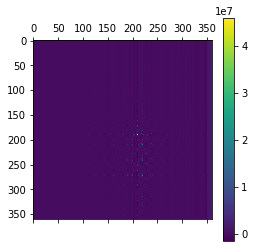

In [38]:
plt.matshow(prec,vmax=np.percentile(prec,100.),vmin=np.percentile(prec,0.5))
plt.colorbar()

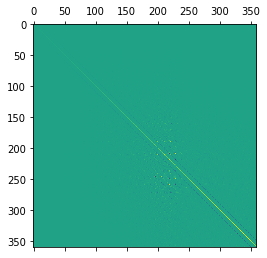

In [39]:
plt.matshow(np.linalg.inv(c_tot))